In [31]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
import wfdb

np.set_printoptions(suppress=True,precision=10)

In [2]:
def obtainMeasures(dbname="mimic",withcentroid=False):
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    limit = "" if withcentroid else " LIMIT 100000 "
    select_stament = ("SELECT qt,ts,sr,centroid FROM rstq "
                      " WHERE qt IS NOT NULL "
                      " AND qt > 0 "
                      " AND ts IS NOT NULL "
                      " AND sr IS NOT NULL "+limit)
    cur.execute(select_stament)
    waves = []
    for row in cur :
        qt = row[0]
        ts = row[1]
        sr = row[2]
        centroid = row[3]
        if withcentroid :
#            centroid = 10 if row[3] is None else row[3]
            waves.append([qt,ts,sr,centroid])
        else :
            waves.append([qt,ts,sr])
    conn.close()
    return waves

In [3]:
fig_size = [12,9]
plt.rcParams["figure.figsize"] = fig_size
def printKmeans(kmeans) :
    labels, values = zip(*collections.Counter(kmeans.labels_).items())
    indexes = np.arange(len(labels))
    width = 0.5
    fig, ax = plt.subplots() 
    for i, v in enumerate(values):
        ax.text(i-0.1,v+1, str(v), color='blue', fontweight='bold')
    plt.bar(indexes, values, width)
    plt.title('Cantidad de Latidos por centroide')
    plt.ylabel('Cantidad de latidos')
    plt.xlabel('Centroides')
    plt.xticks(indexes + width * 0.01, labels)
    plt.show()

In [4]:
waves=obtainMeasures()
centroid=np.array([[50.8323172519,26.14083475,  16.0778474705],
 [12.7398005051,59.3511708549,16.8294447536],
 [111.4642991498,32.3313520427,11.3461741028],
 [247.2540861813,30.3865775136,13.0316988608],
 [-70.8289962825,46.0148698885,24.8141263941],
 [421.7332959012,29.634475014, 15.1005053341],
 [25.2903663501,243.6987788331,103.8195386703],
 [709.7786377709,28.3839009288, 9.3080495356],
 [10.4787581699,154.3071895425,407.9787581699],
 [16.5056179775,525.7280898876,120.4269662921]])
X = np.array(waves)
kmeans = KMeans(n_clusters=10
               # ,init=centroid,n_init=1
               ).fit(X)

In [5]:
centroid = kmeans.cluster_centers_
print(centroid)

[[  11.0576269893   63.1554020532   15.2863030951]
 [  51.2573221757   32.6296120198   11.8854127045]
 [ 136.3262032086   27.679144385    12.9939839572]
 [ 559.8205128205   32.5384615385   14.8205128205]
 [  91.1797464291   31.1189215214    7.6900978976]
 [  23.402528445    42.0553729456   12.8921618205]
 [  74.6480067854   75.5445292621   12.9864291773]
 [ 275.9213114754   32.5606557377   10.668852459 ]
 [  54.1177146438   13.2688531439   11.0890954669]
 [  42.8347355077   23.9128346971    8.7088471438]]


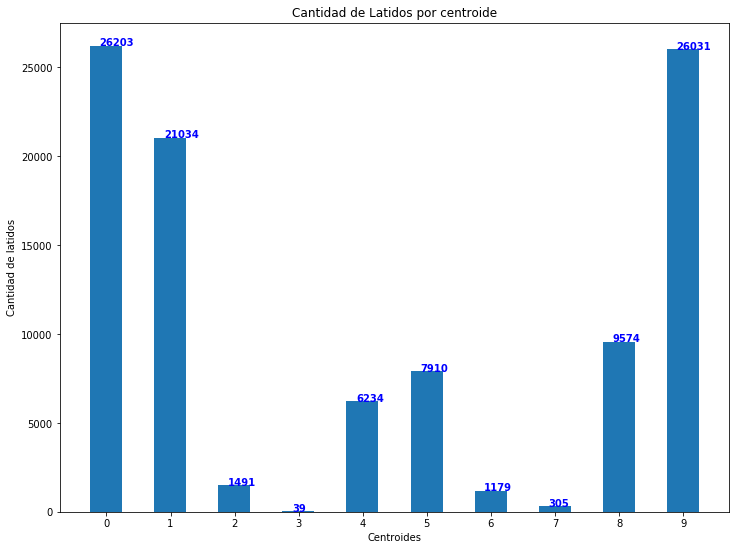

In [6]:
printKmeans(kmeans)

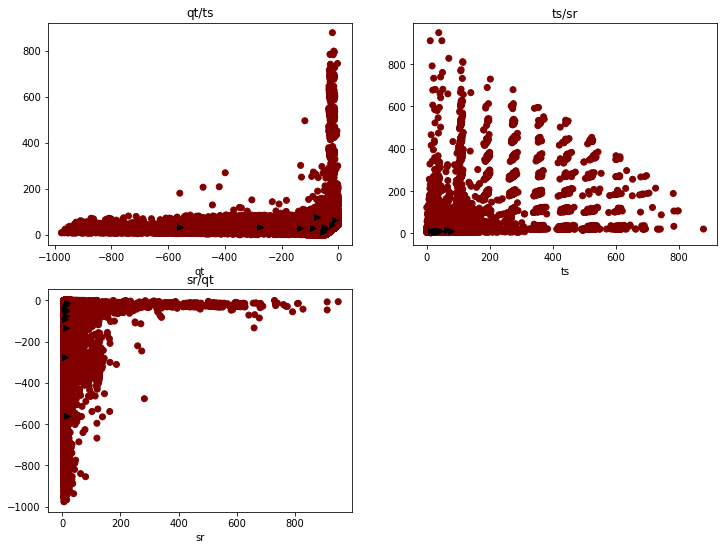

In [7]:
def centroidColor(clist) :
    color = {
        'a': "blue",
        'b': "red",
        'c': "green",
        'd': "magenta",
        'e': "cyan",
        'f': "yellow",
        'g': "limegreen", 
        'h': "pink",
        None : "maroon"
    }
    return [color[x] for x in clist]
#import matplotlib.patches as mpatches
waves = obtainMeasures(withcentroid=True)
qt = np.array([-item[0] for item in waves])
ts = np.array([item[1] for item in waves])
sr = np.array([item[2] for item in waves])
color = np.array([item[3] for item in waves])
qtc = np.array([-int(item[0]) for item in centroid])
tsc = np.array([item[1] for item in centroid])
src = np.array([item[2] for item in centroid])
color = centroidColor(color)
fig = plt.figure()
ax = fig.add_subplot(221)
ax.set_title("qt/ts")
ax.set_xlabel("qt")
ax.scatter(qt,ts, c=color)
ax.scatter(qtc,tsc,c='black', marker=">")
ax = fig.add_subplot(222)
ax.set_title("ts/sr")
ax.set_xlabel("ts")
ax.scatter(ts,sr, c=color)
ax.scatter(tsc,src,c='black', marker=">")
ax = fig.add_subplot(223)
ax.set_title("sr/qt")
ax.set_xlabel("sr")
ax.scatter(sr,qt, c=color)
ax.scatter(src,qtc,c='black', marker=">")
plt.show()

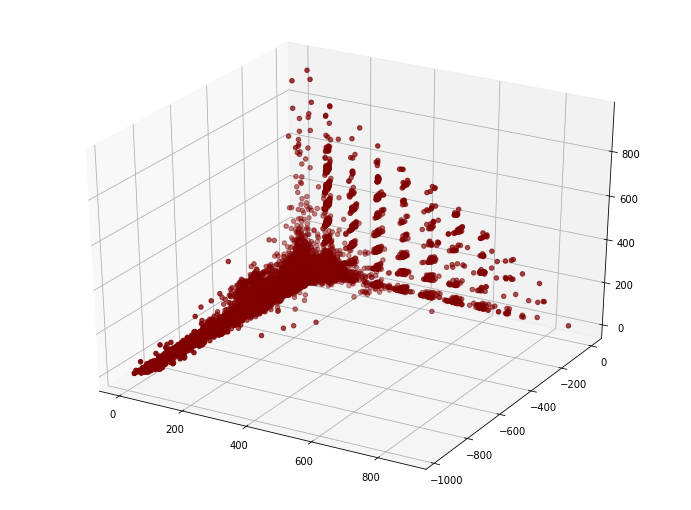

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts,qt, sr, c=color)
ax.scatter(tsc,qtc, src, c='black',marker="^",s=160)
plt.show()

In [58]:
def findCentroid(centroid,window=0,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    qt = str(centroid[0])
    ts = str(centroid[1])
    sr = str(centroid[2])
    strWin = str(window)
    select_stament = ("SELECT rstq.record,r_s,q_s,a.rec_from,a.rec_to "
                      " FROM rstq LEFT JOIN a ON a.record=rstq.record  "
                      " WHERE "
                      " (qt between floor("+qt+")-"+strWin+" and ceil("+qt+")+"+strWin+")"
                      " AND (ts between floor("+ts+")-"+strWin+" and ceil("+ts+")+"+strWin+")"
                      " AND (sr between floor("+sr+")-"+strWin+" and ceil("+sr+")+"+strWin+")"
                      " LIMIT 1")
    cur.execute(select_stament)
    notFound = True
    for row in cur :
        notFound = False
        pbdir = row[0]
        wave = pbdir.split("/")[3]
        pbdir = pbdir.replace("/"+wave,'')
        return {"pbdir":pbdir,"wave":wave,"r_s":row[1],"q_s":row[2],"rec_from":row[3],"rec_to":row[4]}
    if(notFound) :
        return findCentroid(value,window=window+1)

In [85]:
def printCentroid(wave) :
    onda = wave['wave']
    sig, fields = wfdb.srdsamp(onda,pbdir=wave['pbdir'], sampto=1)
    signalII = fields['signame'].index("II")
    sfrom = wave['rec_from']+wave['r_s']-20
    sto   = wave['rec_from']+wave['q_s']
    sto = sfrom+100 if sto-sfrom>100 else sto 
    originalWave = wfdb.rdsamp(onda,pbdir=wave['pbdir'],channels =[signalII], sampfrom=sfrom, sampto=sto).p_signals
#   signalNan = signal[~np.isnan(signal)]
#    subsignal = signalNan[-1800000:]
#    originalWave = subsignal[wave['r_s']:wave['q_s']]
#    print(carpeta,onda,subject_id,recorddate,qrst)
#    cen = wave["centroid"] if wave["centroid"] is not None else "z"
    ax.set_title(" onda:"+onda+"signalII"+str(signalII))
#    plt.scatter(time,amp,c="red")
    ax.plot(originalWave)

In [ ]:
fig = plt.figure()
inx= 1
for value in centroid :
    ax = fig.add_subplot(5,2,inx)
    wave = findCentroid(value)
#    print("wave",wave)
    printCentroid(wave)
    inx=inx+1
plt.show()